## 1. Question Posed

As we all konw, Titanic event is one of the most famous disasters throughout the world. More than 1500 people total died, including passengers and crew, and there were an estimated 2224 people aboard the ship.  I'm curious about the survival rate patterns over age, sex and social statu, e.g. 
- During all the rescues, was the priority given to the elderly and children? What about the females?
- Were people with low social status treated equally during the rescues?

Thus the follwing questions are my concern:

- **What variables are related to survival rate?**

    - What gender has a better survival rate?
    - Among the dead, how old is the oldest person？ And the youngest?
    - What are the survival rate patterns over age?
    - Are those passengers having higher ticket class likely to survive?
    - How does the interpersonal relationships (*siblings/spouses* and *parents/children*) affect the survival rate?
   
   
- **What patterns can I find in the ticket class?**
    - 

https://www.kaggle.com/c/titanic/data

***
## 2. Handling the missing/NA values
Before investigating the survived rata pattern over age, we need to check the **missing/NA values** related to 'Age' and fix them.

In [2]:
# First of all, We need to load datas from the csv file.
# Import required modules
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

# load the csv file
data = pd.read_csv('titanic-data.csv')
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [3]:
# Identify the fields containing missing/NA values and the amount
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
data_by_PclassSex = data.groupby(['Pclass', 'Sex']).mean()['Age']
data_by_PclassSex

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [5]:
# Creat a empty DataFrame to contenate multiple fixed DataFrame
fixed_age = pd.DataFrame(columns=['Age'])

# Replace the NA values of Age with the mean age by categories
for pclass, sex in data_by_PclassSex.index:
    filtered_age = data[(data['Pclass']==pclass) & (data['Sex']==sex)]['Age']
    filtered_age = filtered_age.fillna(data_by_PclassSex.loc[pclass, sex])
    fixed_age = pd.concat([fixed_age, filtered_age])
    
data['Age'] = fixed_age
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,26.5076,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C


---
## 3. Exploring Data and Visualization

In [128]:
age_of_dead = np.array(data[data['Survived']==0]['Age'])
print('Mean age of dead:', np.mean(age_of_dead))
print('Standard deviation age of dead:', np.std(age_of_dead))
print('Maximum age of dead:', np.max(age_of_dead))
print('Minimum age of dead:', np.min(age_of_dead))

('Mean age of dead:', 30.025650613845645)
('Standard deviation age of dead:', 12.758000173300259)
('Maximum age of dead:', 74.0)
('Minimum age of dead:', 1.0)


In [129]:
bin_values = np.arange(start=0, stop=90, step=10)
bin_values

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80])

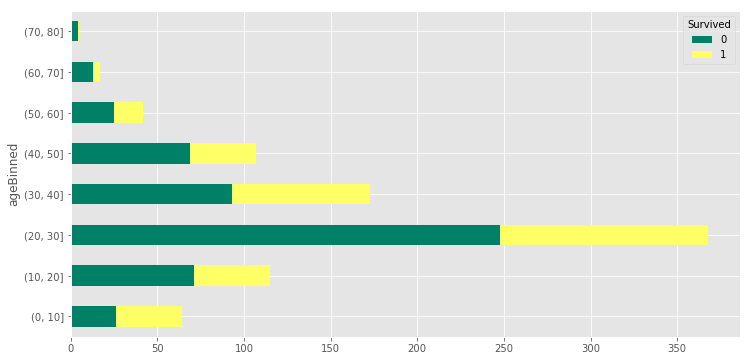

In [189]:
data['ageBinned'] = pd.cut(data['Age'], bins=bin_values)

count_survived_by_ageBinned = data.groupby(['ageBinned', 'Survived']).size().unstack()
count_survived_by_ageBinned.fillna(0, inplace=True)

count_survived_by_ageBinned.plot.barh(stacked=True, colormap='summer', figsize=[12, 6])
plt.show()

**The last bar of the chart above** shows the suvival rate of infant children is more than 50%, significantly higher than other people. We can further get the specific survival rate of children.

In [190]:
# Define a function to add a field called survival rate to the selected dataframe
def add_survivalRate(field_name, selected_data):
    grouped_selected_data = selected_data.groupby([field_name, 'Survived']).size().unstack().reset_index()
    grouped_selected_data[1].fillna(0, inplace=True)
    grouped_selected_data[0].fillna(0, inplace=True)
    grouped_selected_data['proption_survived'] = \
        grouped_selected_data[1] / (grouped_selected_data[0] + grouped_selected_data[1])
    return grouped_selected_data

In [192]:
age_survivalRate = add_survivalRate('ageBinned', data)
age_survivalRate.sort_values(by='proption_survived', ascending=False)

Survived,ageBinned,0,1,proption_survived
0,"(0, 10]",26,38,0.593750
3,"(30, 40]",93,80,0.462428
5,"(50, 60]",25,17,0.404762
1,"(10, 20]",71,44,0.382609
4,"(40, 50]",69,38,0.355140
2,"(20, 30]",248,120,0.326087
6,"(60, 70]",13,4,0.235294
7,"(70, 80]",4,1,0.200000


Thus children aged between 0 and 10 with a survival rate of **nearly 60%**, are the **only** survivors with a survival rate of more than 50%.

So what **gender** has a better survival rate? Does the conclusion apply equally to the children?

In [193]:
# Get the survival rates of differrent genders
add_survivalRate('Sex', data)

Survived,Sex,0,1,proption_survived
0,female,81,233,0.742038
1,male,468,109,0.188908


In [180]:
children = data[(data['Age'] <= 10)]
count_children_by_sex = children.groupby(['Sex', 'Survived']).size().unstack()
count_children_by_sex

Survived,0,1
Sex,,
female,12,19
male,14,19


The survival rate of female is more than 4 times that of male. It seems that **women** have acquired enough respects in rescues. However, the preferential treatment doesn't aplly to children.


Still a small number of women are excluded from the list of survivors. So what is the common characteristic of those **servived women**? Does the characteristic include the **pclass**, which represents the social status?

Before this, the relationship between the overall survival rate and pclass will be investigated.

In [206]:
add_survivalRate('Pclass', data)

Survived,Pclass,0,1,proption_survived
0,1,80,136,0.629630
1,2,97,87,0.472826
2,3,372,119,0.242363


In [198]:
females = data[data['Sex']=='female']
count_females_by_pclass = females.groupby(['Pclass', 'Survived']).size().unstack()
count_females_by_pclass

Survived,0,1
Pclass,,
1,3,91
2,6,70
3,72,72


In [203]:
count_females_by_pclass['proption_survived'] = count_females_by_pclass[1] \
    / (count_females_by_pclass[0] + count_females_by_pclass[1])
count_females_by_pclass

Survived,0,1,proption_survived
Pclass,,,
1,3,91,0.968085
2,6,70,0.921053
3,72,72,0.500000


The numbers above indicate there are only 3 fields containing missing/NA values: **_Age, Cabin_** and **_Embarked_**.  _Age_, filling the NaN with **mean** value shold be a better choice.

In [ ]:
def survived_plot(field):
    by_pclass = data.groupby([field]).mean()    
    bar_title = 'Mean survived people by %s' % field
    plot_frame = by_pclass['Survived']
    
    plot_frame.plot.bar(title=bar_title, color='k', alpha=0.5)
    plt.show()

In [ ]:
survived_plot('Pclass')

In [ ]:
survived_plot('Sex')

In [ ]:
by_pclass_sex = data.groupby(['Pclass', 'Sex']).mean()['Survived']

In [ ]:
by_pclass_sex = pd.pivot_table(data, index=['Pclass'], columns=['Sex'], aggfunc='mean')
by_pclass_sex

In [ ]:
by_pclass_sex.plot.bar(title=bar_title)
plt.show()

In [ ]:
corr_coef('Age')

In [ ]:
corr_coef('Survived', 'Pclass')

In [ ]:
data_by_pclass = data.groupby('Pclass').mean()
Survived = data_by_pclass['Survived']

In [ ]:
Survived.plot.bar(color='k', alpha=0.5)
plt.show()

In [ ]:
by_survived = df.groupby('Survived')
by_survived.mean()

In [ ]:
by_pclass = data.groupby(['Pclass']).mean()

bar_title = 'Mean survived people by %s' % 'Pclass'

by_pclass['Survived'].plot.bar(title=bar_title, color='k', alpha=0.5)
plt.show()

## 4. Drawing Conclusions

## 5. Data Visualization

In [ ]:
# Locate the items containing NaN attacked to 'Embarked'.
df[df['Embarked'].isnull().values==True]


# Replace the values of 'Sex' with 0 and 1
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1}).astype(str).astype(int)

In [ ]:
def corr_coef(item):
    Person_r = np.corrcoef(data['Survived'], data[item])
    print "The correlation coefficient between Survived and %s is: %r." % (item, Person_r[0, 1])
    grouped = data.groupby(item, as_index=False).mean()
    bar_title = 'Mean survived people by %s' % item 
    grouped[item].plot.bar(title=bar_title, color='k', alpha=0.5)
    plt.show()

In [ ]:
# Abandon those entries where the values of 'Emvarked' are NaN
data['Embarked'].dropna(inplace=True)